In [84]:
import string
import re
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from multiprocessing.pool import ThreadPool as Pool 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection
import lightgbm as lgb
import pickle
from flask import Flask, request 
from scipy.sparse import hstack
from sklearn import metrics
import numpy as np
from pathlib import Path
import os

##  Note: in addition, there are rooms to improve the preprocess, and parameter optimization.

In [36]:
def preprocess(text: string, stopword_set: set = set(stopwords.words()) , stemmer: PorterStemmer =PorterStemmer()): 
    cleaned_text = text.translate(str.maketrans('', '', '!"#$%&\'()*+,.<=>?@[]^`{|}~' + u'\xa0'))
    cleaned_text = cleaned_text.lower()
    cleaned_text = cleaned_text.translate(str.maketrans(string.whitespace, ' ' * len(string.whitespace), ''))
    cleaned_text = ' '.join(['_variable_with_underscore' if '_' in t else t for t in cleaned_text.split()])
    cleaned_text = ' '.join(['_variable_with_dash' if '-' in t else t for t in cleaned_text.split()])
    cleaned_text = ' '.join(['_long_variable_name' if len(t) > 15 and t[0] != '#' else t for t in cleaned_text.split()])
    cleaned_text = ' '.join(['_weburl' if t.startswith('http') and '/' in t else t for t in cleaned_text.split()])
    cleaned_text = ' '.join(['_number' if re.sub('[\\/;:_-]', '', t).isdigit() else t for t in cleaned_text.split()])
    cleaned_text = ' '.join(['_variable_with_address' if re.match('.*0x[0-9a-f].*', t) else t for t in cleaned_text.split()])
    cleaned_text = ' '.join(['_name_with_number' if re.match('.*[a-f]*:[0-9]*', t) else t for t in  cleaned_text.split()])
    cleaned_text = ' '.join(['_number_starts_with_one_character' if re.match('[a-f][0-9].*', t) else t for t in cleaned_text.split()])
    cleaned_text = ' '.join(['_number_starts_with_three_characters' if re.match('[a-f]{3}[0-9].*', t) else t for t in cleaned_text.split()])
    cleaned_text = ' '.join(['_version' if any(i.isdigit() for i in t) and t.startswith('v') else t for t in cleaned_text.split()])
    cleaned_text = ' '.join(['_localpath' if ('\\' in t or '/' in t) and ':' not in t else t for t in cleaned_text.split()])
    cleaned_text = ' '.join(['_image_size' if t.endswith('px') else t for t in cleaned_text.split()])

    tokenized_text = word_tokenize(cleaned_text)
    sw_removed_text = [word for word in tokenized_text if word not in stopword_set]
    sw_removed_text = [word for word in tokenized_text if len(word) > 0]
    stemmed_text = ' '.join([stemmer.stem(w) for w in sw_removed_text])
    return stemmed_text

In [89]:
dataset = pd.read_json('resource/embold_train.json') 
dataset.loc[dataset['label'] > 0, 'label'] = -1 
dataset.loc[dataset['label'] == 0, 'label'] = 1 
dataset.loc[dataset['label'] == -1, 'label'] = 0
stopwords = set(stopwords.words('english')) 
ps = PorterStemmer()

dataset = dataset.loc[:100000]


In [90]:
dataset

,title,body,label
0,y-zoom piano roll,a y-zoom on the piano roll would be useful.,0
1,buggy behavior in selection,! screenshot from 2016-02-23 21 27 40 https:/...,1
2,auto update feature,"hi,\r \r great job so far, @saenzramiro ! : \r...",0
3,filter out noisy endpoints in logs,i think we should stop logging requests to:\r ...,0
4,enable pid on / pid off alarm actions for ardu...,expected behavior\r alarm actions pid on and p...,1
...,...,...,...
99996,command palette: generate toc gfm,github flavored markdown creates html anchors ...,0
99997,difficulty filter for extra exercises is broken,difficulty filter for extra exercises on the b...,1
99998,ghostauth redirect uri mismatch error for urls...,"if you are using ghostauth, and have the url i...",1
99999,port is never passed as argument in compose.co...,port parameter is always replaced with empty s...,1


In [38]:
stopword_set = None
stemmer = None
def initialize_pool(stopword_set_arg, stemmer_arg):
    global stopword_set
    global stemmer
    stopword_set = stopword_set_arg
    stemmer = stemmer_arg

In [39]:
pool = Pool(8)

pool = Pool(8, initializer=initialize_pool, initargs=(stopwords, ps, )) 

In [40]:
cleaned_title = pool.map(preprocess, dataset.title)

In [41]:
cleaned_title

['_long_variable_nam piano roll',
 'buggi behavior in select',
 'auto updat featur',
 'filter out noisi endpoint in log',
 'enabl pid on _localpath pid off alarm action for _localpath',
 'script stop ad video',
 'add the translat of _long_variable_nam',
 'propos loadtransl to lazi load _long_variable_nam',
 'bot should post to list period instead of onli post on startup',
 'en la org _long_variable_nam peopl info _localpath produc crash',
 '_name_with_numb check result against train data',
 'null or in jsonexport',
 'custom averag in _long_variable_nam',
 'add consist cach via separ process',
 '_long_variable_nam support pagin',
 'filter float point',
 'i2cwrit error on debian _number can not read properti i2cwritesync of undefin',
 'handl search which yield no result better',
 'path of war _long_variable_nam manuev il',
 'implement iap in app purchas subscript on io',
 'block that can be place face a particular direct are sometim place wrong',
 'app break when chang month after the ac

In [42]:
cleaned_body = pool.map(preprocess, dataset.body)

In [43]:
cleaned_body

['a _long_variable_nam on the piano roll would be use',
 'screenshot from _long_variable_nam _number _number _number _long_variable_nam _localpath',
 '_localpath _localpath great job so far saenzramiro _name_with_numb _localpath _localpath an auto updat featur would be nice to _localpath or altern a menu button to check for the latest version manual',
 'i think we should stop log request _name_with_numb _long_variable_nam _long_variable_nam _localpath _long_variable_nam _long_variable_nam _localpath _long_variable_nam faviconico _localpath',
 'expect _localpath alarm action pid on and pid off should enabl _localpath disabl hardwar pid on _localpath platform rampsoak on _localpath off may also be _localpath _localpath actual _localpath pid state on _localpath doe not chang when alarm _localpath _localpath step to reproduc the _localpath alarm handler onli work if _long_variable_nam is set sw onli _long_variable_nam case is handl in pidon _localpath pidoff function so thi condit may be a

In [48]:
data_texts = pd.DataFrame([cleaned_title, cleaned_body], index=['title','body']).T 
y = dataset['label'] 

data_fit, data_blindtest, y_fit, y_blindtest = model_selection.train_test_split(data_texts, y, test_size=0.1) 

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1)) 
tfidf_vectorizer.fit(cleaned_title + cleaned_body) 

X_tfidf_fit = tfidf_vectorizer.transform(data_fit['title']) 
X_tfidf_blindtest = tfidf_vectorizer.transform(data_blindtest['title'])

In [49]:
gbm_model = lgb.LGBMClassifier()

precision_cv_score = model_selection.cross_val_score(gbm_model, X_tfidf_fit, y_fit, cv=5, n_jobs=-2,scoring='precision').mean()
recall_cv_score = model_selection.cross_val_score(gbm_model, X_tfidf_fit, y_fit, cv=5, n_jobs=-2, scoring='recall_macro').mean() 
f1_cv_score = model_selection.cross_val_score(gbm_model, X_tfidf_fit, y_fit, cv=5, n_jobs=-2, scoring='f1_macro').mean() 

print('CV: p:{0:.4f} r:{1:.4f} f:{2:.4f}'.format(precision_cv_score, recall_cv_score, f1_cv_score)) 

CV: p:0.7859 r:0.7870 f:0.7887


In [50]:
data_fit_train, data_fit_test, y_fit_train, y_fit_test = model_selection.train_test_split(data_fit, y_fit, test_size=0.3) 

X_tfidf_fit_train = tfidf_vectorizer.transform(data_fit_train['title']) 
X_tfidf_fit_test = tfidf_vectorizer.transform(data_fit_test['title']) 
X_tfidf_blindtest = tfidf_vectorizer.transform(data_blindtest['title']) 

gbm_model.fit(X_tfidf_fit_train, y_fit_train, eval_set=[(X_tfidf_fit_test, y_fit_test)], eval_metric='AUC') 
precision_test_score = metrics.precision_score(gbm_model.predict(X_tfidf_blindtest), y_blindtest, average='macro') 
recall_test_score = metrics.recall_score(gbm_model.predict(X_tfidf_blindtest), y_blindtest, average='macro') 
f1_test_score = metrics.f1_score(gbm_model.predict(X_tfidf_blindtest), y_blindtest, average='macro') 

print('test: p:{0:.4f} r:{1:.4f} f:{2:.4f}'.format(precision_test_score, recall_test_score, f1_test_score)) 


[LightGBM] [Info] Number of positive: 19646, number of negative: 24454
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050624 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 63585
[LightGBM] [Info] Number of data points in the train set: 44100, number of used features: 1518
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.445488 -> initscore=-0.218920
[LightGBM] [Info] Start training from score -0.218920
test: p:0.7914 r:0.7964 f:0.7931


### Sk-learn LSA

In [52]:
from sklearn.decomposition import TruncatedSVD 

lsa = TruncatedSVD(n_components=500, n_iter=100, random_state=0) 
lsa.fit(X_tfidf_fit) 
X_lsa_fit = lsa.transform(X_tfidf_fit) 

gbm_model_with_lsa = lgb.LGBMClassifier() 

precision_cv_score = model_selection.cross_val_score(gbm_model_with_lsa, X_lsa_fit, y_fit, cv=5, n_jobs=-2, scoring='precision_macro').mean() 
recall_cv_score = model_selection.cross_val_score(gbm_model_with_lsa, X_lsa_fit, y_fit, cv=5, n_jobs=-2, scoring='recall_macro').mean() 
f1_cv_score = model_selection.cross_val_score(gbm_model_with_lsa, X_lsa_fit, y_fit, cv=5, n_jobs=-2, scoring='f1_macro').mean() 

print('fit: p:{0:.4f} r:{1:.4f} f:{2:.4f}'.format(precision_cv_score, recall_cv_score, f1_cv_score)) 



fit: p:0.7677 r:0.7652 f:0.7662


In [53]:
X_fit_with_lsa = hstack([X_tfidf_fit, X_lsa_fit]).tocsr() 

precision_cv_score = model_selection.cross_val_score(gbm_model_with_lsa, X_fit_with_lsa, y_fit, cv=5, n_jobs=-2, scoring='precision_macro').mean() 
recall_cv_score = model_selection.cross_val_score(gbm_model_with_lsa, X_fit_with_lsa, y_fit, cv=5, n_jobs=-2, scoring='recall_macro').mean() 
f1_cv_score = model_selection.cross_val_score(gbm_model_with_lsa, X_fit_with_lsa, y_fit, cv=5, n_jobs=-2, scoring='f1_macro').mean() 

print('fit: p:{0:.4f} r:{1:.4f} f:{2:.4f}'.format(precision_cv_score, recall_cv_score, f1_cv_score))

fit: p:0.7812 r:0.7780 f:0.7792


### Sk-learn LDA

In [54]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(ngram_range=(1,1))
count_vectorizer.fit(cleaned_title + cleaned_body)
X_tf_fit = count_vectorizer.transform(data_fit['title'])
X_tfidf_blindtest = count_vectorizer.transform(data_blindtest['title'])
lda = LatentDirichletAllocation(n_components=500, random_state=0)
lda.fit(X_tf_fit)
X_lda_fit = lda.transform(X_tf_fit)
gbm_model_with_lda = lgb.LGBMClassifier()


In [55]:
precision_cv_score = model_selection.cross_val_score(gbm_model_with_lda, X_lda_fit, y_fit, cv=5, n_jobs=-2, scoring='precision_macro').mean()
recall_cv_score = model_selection.cross_val_score(gbm_model_with_lda, X_lda_fit, y_fit, cv=5, n_jobs=-2, scoring='recall_macro').mean()
f1_cv_score = model_selection.cross_val_score(gbm_model_with_lda, X_lda_fit, y_fit, cv=5, n_jobs=-2, scoring='f1_macro').mean()

print('fit: p:{0:.4f} r:{1:.4f} f:{2:.4f}'.format(precision_cv_score, recall_cv_score, f1_cv_score))

fit: p:0.7209 r:0.7132 f:0.7149


In [56]:
X_fit_with_lda = hstack([X_tfidf_fit, X_lda_fit]).tocsr()

precision_cv_score = model_selection.cross_val_score(gbm_model_with_lda, X_fit_with_lda, y_fit, cv=5, n_jobs=-2, scoring='precision_macro').mean()
recall_cv_score = model_selection.cross_val_score(gbm_model_with_lda, X_fit_with_lda, y_fit, cv=5, n_jobs=-2, scoring='recall_macro').mean()
f1_cv_score = model_selection.cross_val_score(gbm_model_with_lda, X_fit_with_lda, y_fit, cv=5, n_jobs=-2, scoring='f1_macro').mean()

print('fit: p:{0:.4f} r:{1:.4f} f:{2:.4f}'.format(precision_cv_score, recall_cv_score, f1_cv_score))

fit: p:0.7902 r:0.7855 f:0.7871


In [58]:
import optuna

def objective(trial): 
    dtrain = lgb.Dataset(X_tfidf_fit_train, label=y_fit_train) 

    param = { 
    "objective": "binary", 
    "metric": "binary_logloss", 
    "verbosity": -1, 
    "boosting_type": "gbdt", 
    "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True), 
    "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True), 
    "num_leaves": trial.suggest_int("num_leaves", 2, 256), 
    "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0), 
    "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0), 
    "bagging_freq": trial.suggest_int("bagging_freq", 1, 7), 
    "min_child_samples": trial.suggest_int("min_child_samples", 5, 100), 
    } 

    gbm = lgb.train(param, dtrain) 
    preds = gbm.predict(X_tfidf_fit_test) 
    pred_labels = np.rint(preds) 
    accuracy = metrics.roc_auc_score(y_fit_test, pred_labels) 
    return accuracy 



## Tf-idf+LSA+LDA

###  • Try to find-tune to get the highest CV accuracy possible; 

In [77]:
lda_lsa_study = optuna.create_study(direction="maximize") 
lda_lsa_study.optimize(objective, n_trials=50) 

[I 2024-03-09 16:42:58,746] A new study created in memory with name: no-name-6c3520dc-5fbe-4f32-ac41-98a9fea48dce
[I 2024-03-09 16:43:01,333] Trial 0 finished with value: 0.7860120102782464 and parameters: {'lambda_l1': 6.266997814673988e-07, 'lambda_l2': 3.965218696985265e-07, 'num_leaves': 82, 'feature_fraction': 0.7662181443412389, 'bagging_fraction': 0.40212199048730596, 'bagging_freq': 4, 'min_child_samples': 23}. Best is trial 0 with value: 0.7860120102782464.
[I 2024-03-09 16:43:07,117] Trial 1 finished with value: 0.7841951322756315 and parameters: {'lambda_l1': 0.008643355008487551, 'lambda_l2': 0.0018194144373050128, 'num_leaves': 241, 'feature_fraction': 0.79121590257699, 'bagging_fraction': 0.5808801041289676, 'bagging_freq': 4, 'min_child_samples': 14}. Best is trial 0 with value: 0.7860120102782464.
[I 2024-03-09 16:43:11,356] Trial 2 finished with value: 0.786900252674162 and parameters: {'lambda_l1': 1.9019040928825252e-07, 'lambda_l2': 5.7331118194512876e-05, 'num_leav

In [78]:
trial_lda_lsa = lda_lsa_study.best_trial
trial_lda_lsa.params

{'lambda_l1': 0.00012565642787078864,
 'lambda_l2': 1.5963695915605343,
 'num_leaves': 114,
 'feature_fraction': 0.6506203736379466,
 'bagging_fraction': 0.829189621336442,
 'bagging_freq': 1,
 'min_child_samples': 17}

## Show the final accuracy

In [79]:
X_combined_lsa = hstack([X_tfidf_fit, X_lsa_fit]).tocsr()
X_combined_all = hstack([X_tfidf_fit, X_lda_fit]).tocsr()

gbm_model_with_combined = lgb.LGBMClassifier(**trial_lda_lsa.params)

precision_cv_score = model_selection.cross_val_score(gbm_model_with_combined, X_combined_all, y_fit, cv=5, n_jobs=-2)
recall_cv_score = model_selection.cross_val_score(gbm_model_with_combined, X_combined_all, y_fit, cv=5, n_jobs=-2)
f1_cv_score = model_selection.cross_val_score(gbm_model_with_combined, X_combined_all, y_fit, cv=5, n_jobs=-2)

print('fit: p:{0:.4f} r:{1:.4f} f:{2:.4f}'.format(precision_cv_score.mean(), recall_cv_score.mean(), f1_cv_score.mean()))

fit: p:0.7943 r:0.7943 f:0.7943


In [80]:
gbm_model_with_combined.fit(X_combined_all, y_fit, eval_set=[(X_tfidf_fit_test, y_fit_test)],eval_metric='AUC')

precision_test_score = metrics.precision_score(gbm_model_with_combined.predict(X_combined_all), y_fit, average='macro')
recall_test_score = metrics.recall_score(gbm_model_with_combined.predict(X_combined_all), y_fit, average='macro')
f1_test_score = metrics.f1_score(gbm_model_with_combined.predict(X_combined_all), y_fit, average='macro')

print('test: p:{0:.4f} r:{1:.4f} f:{2:.4f}'.format(precision_test_score, recall_test_score, f1_test_score))


[LightGBM] [Warning] feature_fraction is set=0.6506203736379466, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6506203736379466
[LightGBM] [Warning] lambda_l1 is set=0.00012565642787078864, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00012565642787078864
[LightGBM] [Warning] lambda_l2 is set=1.5963695915605343, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5963695915605343
[LightGBM] [Warning] bagging_fraction is set=0.829189621336442, subsample=1.0 will be ignored. Current value: bagging_fraction=0.829189621336442
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6506203736379466, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6506203736379466
[LightGBM] [Warning] lambda_l1 is set=0.00012565642787078864, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00012565642787078864
[LightGBM] [Warning] la

In [1]:
pickle.dump(tfidf_vectorizer, open('resource/github_bug_prediction_tfidf_vectorizer.pkl', 'wb')) 
pickle.dump(gbm_model_with_combined, open('resource/github_bug_prediction_basic_model.pkl', 'wb'))

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\ASUS\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\ASUS\AppData\Local\Temp\ipykernel_12920\1001500380.py", line 1, in <module>
    pickle.dump(tfidf_vectorizer, open('resource/github_bug_prediction_tfidf_vectorizer.pkl', 'wb'))
    ^^^^^^
NameError: name 'pickle' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\ASUS\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 2105, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ASUS\AppData\Roaming\Python\Python311\site-packages\IPython\core\ultratb.py", line 1428, in structured_traceback
    return FormattedTB.structured_traceback(
           ^^^^^^^^^^^^^^

## Finally, integrate your best configured integration into the flask application


In [85]:
app = Flask(__name__)
dir = Path(os.path.abspath(''))
print(dir / 'resource/github_bug_prediction_tfidf_vectorizer.pkl' )
app.tfidf_vec = pickle.load(open(dir / 'resource/github_bug_prediction_tfidf_vectorizer.pkl', 'rb'))
app.basic_model = pickle.load(open(dir / 'resource/github_bug_prediction_basic_model.pkl', 'rb'))
app.stopword_set = set(stopwords.words())
app.stemmer = PorterStemmer()

@app.route('/predict_basic', methods=['GET'])
def predict_basic():
    res_obj = {'status': 'success'}
    argsList = request.args.to_dict(flat=False)
    title = argsList['title'][0]
    body = argsList['body'][0]
    predict = app.basic_model.predict_proba(hstack([app.tfidf_vec.transform([preprocess(title, app.stopword_set, app.stemmer)])]))
    res_obj['predict_as'] = 'bug' if predict[0][1] > 0.5 else 'not bug'
    res_obj['bug_prob'] = predict[0][1] 
    return res_obj

d:\3rd Year(SE)\Semester 2\IR - Information Retrieval\Assignment\481 -#7-2\assignment\resource\github_bug_prediction_tfidf_vectorizer.pkl


In [92]:
app.run(debug=False)

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [09/Mar/2024 17:05:46] "GET /predict_basic?title=y-zoom&body=a%20y-zoom HTTP/1.1" 200 -
127.0.0.1 - - [09/Mar/2024 17:06:13] "GET /predict_basic?title=buggy%20behavior&body=!%20screenshot HTTP/1.1" 200 -
127.0.0.1 - - [09/Mar/2024 17:06:44] "GET /predict_basic?title=enable%20pid%20on&body=expected HTTP/1.1" 200 -


### Postman query

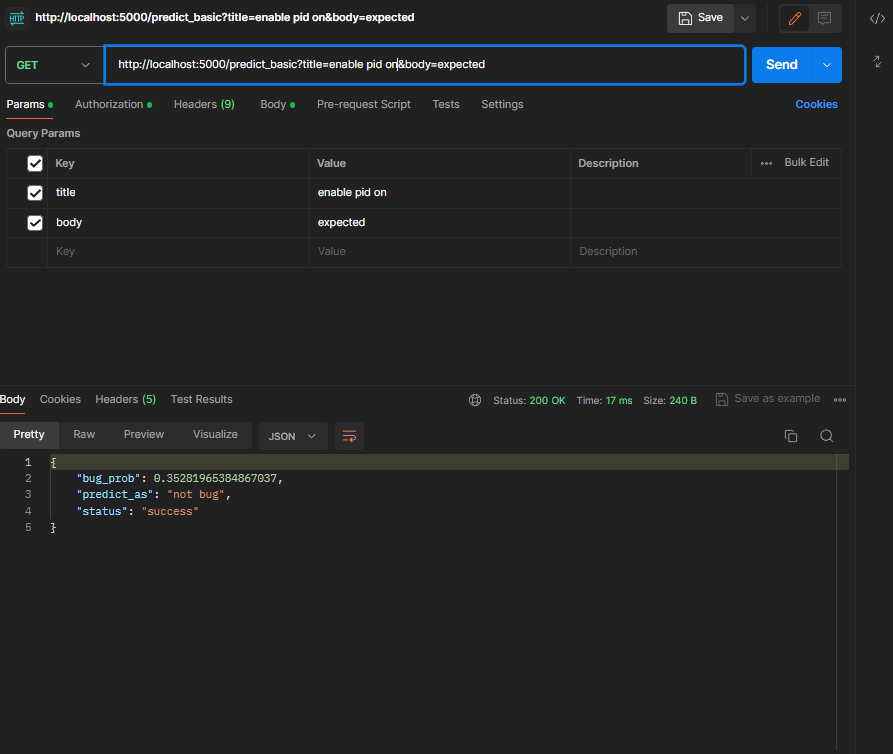